![](Zillow.jpg)

# Zillow Clustering Project: Predicting Logerror of Zestimate
## Natasha Rivers
### June 28, 2021

<hr style="border:2px solid black"> </hr>

## Goals: 
- To find what is driving the errors in the Zillow Zestimate
- 'logerror'= predicted sale value - actual sale value

## Executive Summary:
- 

<hr style="border:2px solid black"> </hr>

### Imports

In [1]:
import acquire
import prepare
import explore

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score

import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid black"> </hr>

## Acquire

In [2]:
#function from acquire.py 
zillow = acquire.get_zillow_file()

In [3]:
zillow.head()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,transactiondate
0,14297519,0.025595,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,53571.0,1286.0,96978.0,1998.0,485713.0,1023282.0,537569.0,11013.72,2017-01-01
1,17052889,0.055619,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,13091.0,2061.0,97099.0,1967.0,88000.0,464000.0,376000.0,5672.48,2017-01-01
2,14186244,0.005383,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,21412.0,1286.0,97078.0,1962.0,85289.0,564778.0,479489.0,6488.30,2017-01-01
3,12177905,-0.103410,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,396551.0,3101.0,96330.0,1970.0,108918.0,145143.0,36225.0,1777.51,2017-01-01
4,12095076,-0.001011,3.0,4.0,2962.0,6037.0,34145202.0,-118179824.0,63000.0,47019.0,3101.0,96293.0,1950.0,276684.0,773303.0,496619.0,9516.26,2017-01-01


In [4]:
zillow.dtypes

parcelid                          int64
logerror                        float64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fips                            float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
regionidcity                    float64
regionidcounty                  float64
regionidzip                     float64
yearbuilt                       float64
structuretaxvaluedollarcnt      float64
taxvaluedollarcnt               float64
landtaxvaluedollarcnt           float64
taxamount                       float64
transactiondate                  object
dtype: object

In [5]:
#52442 entries,17 columns several nulls, incorrect dtypes
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52442 non-null  int64  
 1   logerror                      52442 non-null  float64
 2   bathroomcnt                   52442 non-null  float64
 3   bedroomcnt                    52442 non-null  float64
 4   calculatedfinishedsquarefeet  52360 non-null  float64
 5   fips                          52442 non-null  float64
 6   latitude                      52442 non-null  float64
 7   longitude                     52442 non-null  float64
 8   lotsizesquarefeet             52073 non-null  float64
 9   regionidcity                  51405 non-null  float64
 10  regionidcounty                52442 non-null  float64
 11  regionidzip                   52416 non-null  float64
 12  yearbuilt                     52326 non-null  float64
 13  s

In [6]:
zillow.shape

(52442, 18)

## Takeaways from Acquire:
- based somewhat on personal interpretation, different "propertylandusetypeid" may be used. 
    - ended up settling on "261" (single-family residential)
- creating a function to save get_zillow into a csv will drastically reduce time to import
- 52,442 entries
- 18 different columns
    - appear to have some nulls (further explore this in prepare)

<hr style="border:2px solid black"> </hr>

## Prepare

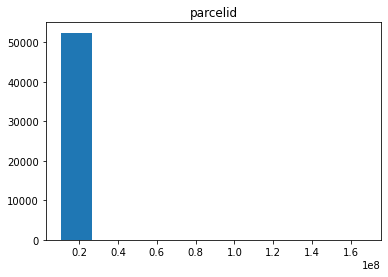

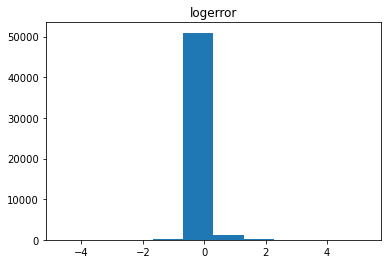

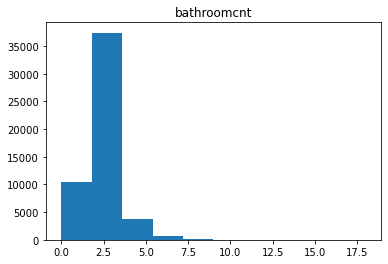

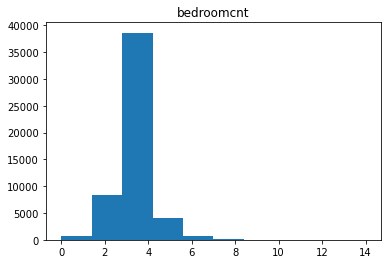

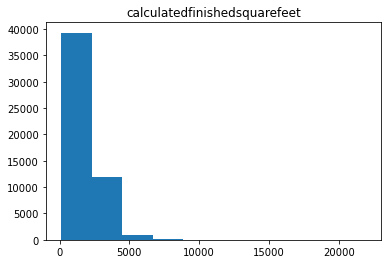

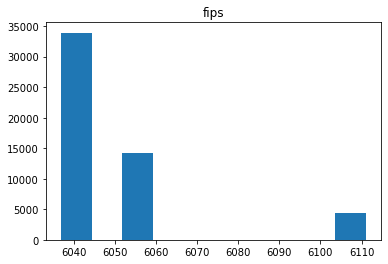

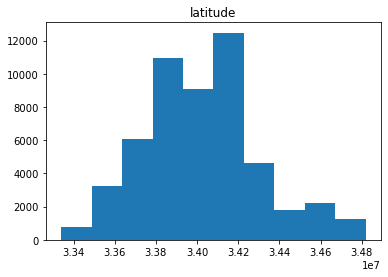

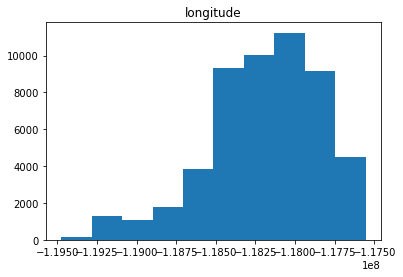

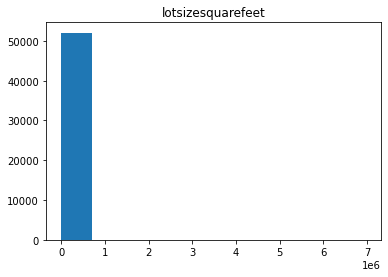

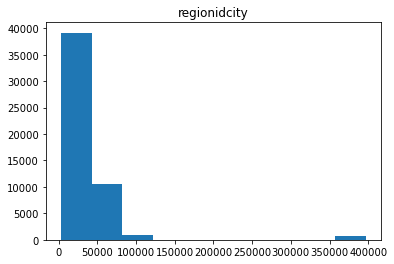

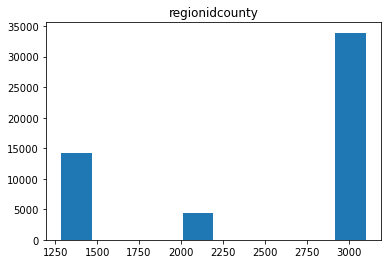

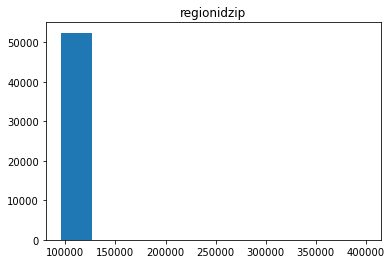

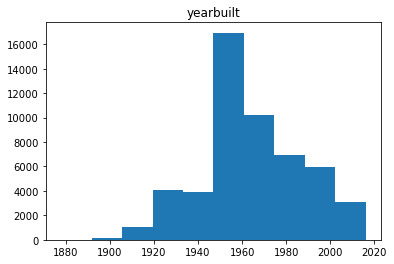

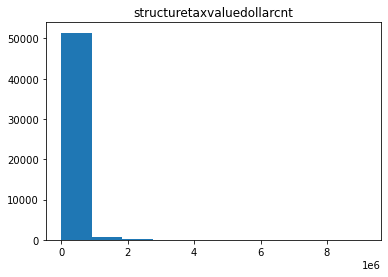

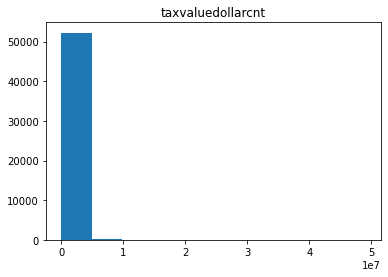

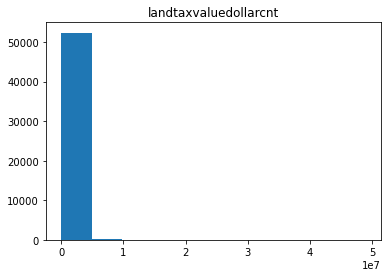

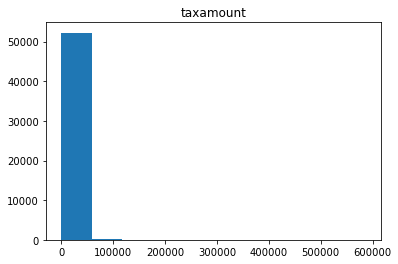

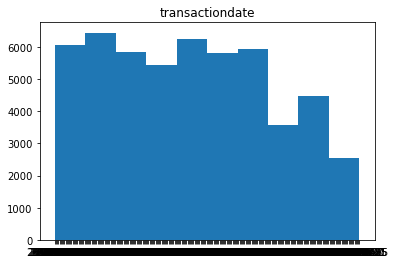

In [7]:
#visualize distributions 
#check for outliers
for col in zillow.columns:
    plt.hist(zillow[col])
    plt.title(col)
    plt.show()

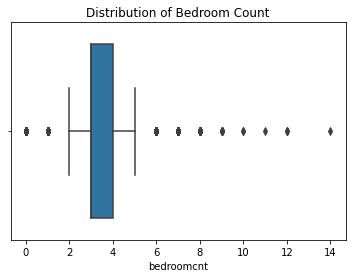

In [8]:
#specifically visualize outliers in bedroom
sns.boxplot(zillow.bedroomcnt)
plt.title('Distribution of Bedroom Count')
plt.show()

In [9]:
#look at null values
zillow.isnull().sum()

parcelid                           0
logerror                           0
bathroomcnt                        0
bedroomcnt                         0
calculatedfinishedsquarefeet      82
fips                               0
latitude                           0
longitude                          0
lotsizesquarefeet                369
regionidcity                    1037
regionidcounty                     0
regionidzip                       26
yearbuilt                        116
structuretaxvaluedollarcnt        84
taxvaluedollarcnt                  1
landtaxvaluedollarcnt              1
taxamount                          4
transactiondate                    0
dtype: int64

In [10]:
#take a look at how many nulls there are by row
explore.nulls_by_col(zillow)

,num_rows_missing,pct_rows_missing
parcelid,0,0.000000
logerror,0,0.000000
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
calculatedfinishedsquarefeet,82,0.156363
fips,0,0.000000
latitude,0,0.000000
longitude,0,0.000000
lotsizesquarefeet,369,0.703634
regionidcity,1037,1.977423


In [11]:
#take a look at how many nulls there are by row
explore.nulls_by_row(zillow)

,num_cols_missing,pct_cols_missing,num_rows
0,0,0.0,50913
1,1,5.555555555555555,1386
2,2,11.11111111111111,105
3,3,16.666666666666664,32
4,4,22.22222222222222,4
5,6,33.33333333333333,2


In [12]:
#function from prepare.py that changes column names, changes dtypes, 
#imputes values, drop nulls and outliers, creates new column with county name

zillow = prepare.final_prep_zillow(zillow)

In [13]:
#as you can see.. column names have been changed
zillow.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,county
0,14297519,0.025595,3.5,4,3100,6059,33634931,-117869207,4506,53571,1286,96978,1998,485713,1023282,537569,11013,2017-01-01,orange
1,17052889,0.055619,1.0,2,1465,6111,34449266,-119281531,12647,13091,2061,97099,1967,88000,464000,376000,5672,2017-01-01,ventura
2,14186244,0.005383,2.0,3,1243,6059,33886168,-117823170,8432,21412,1286,97078,1962,85289,564778,479489,6488,2017-01-01,orange
3,12177905,-0.103410,3.0,4,2376,6037,34245180,-118240722,13038,396551,3101,96330,1970,108918,145143,36225,1777,2017-01-01,los_angeles
4,12095076,-0.001011,3.0,4,2962,6037,34145202,-118179824,63000,47019,3101,96293,1950,276684,773303,496619,9516,2017-01-01,los_angeles


In [14]:
#prepare.py also changed dtypes
zillow.dtypes

parcelid                        int64
logerror                      float64
bathrooms                     float64
bedrooms                        int64
total_sqft                      int64
county_code                     int64
latitude                        int64
longitude                       int64
lotsizesquarefeet               int64
regionidcity                    int64
regionidcounty                  int64
regionidzip                     int64
year_built                      int64
structuretaxvaluedollarcnt      int64
value_assessed                  int64
landtaxvaluedollarcnt           int64
tax_amount                      int64
transactiondate                object
county                         object
dtype: object

In [15]:
#prepare.py dropped nulls outside of threshold and imputed values 
zillow.isnull().sum()

parcelid                      0
logerror                      0
bathrooms                     0
bedrooms                      0
total_sqft                    0
county_code                   0
latitude                      0
longitude                     0
lotsizesquarefeet             0
regionidcity                  0
regionidcounty                0
regionidzip                   0
year_built                    0
structuretaxvaluedollarcnt    0
value_assessed                0
landtaxvaluedollarcnt         0
tax_amount                    0
transactiondate               0
county                        0
dtype: int64

In [16]:
#new shape after dropping outliers and nulls that were not imputed
zillow.shape

(48236, 19)

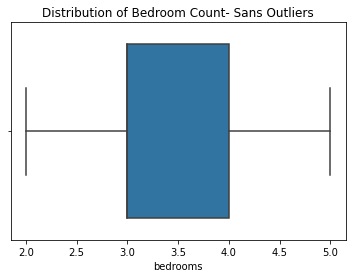

In [17]:
#visual that outliers were dropped 
sns.boxplot(zillow.bedrooms)
plt.title('Distribution of Bedroom Count- Sans Outliers')
plt.show()

In [18]:
#take a look at our target
zillow.logerror.describe()

count    48236.000000
mean         0.016362
std          0.168416
min         -4.655420
25%         -0.025022
50%          0.005964
75%          0.037957
max          3.394544
Name: logerror, dtype: float64

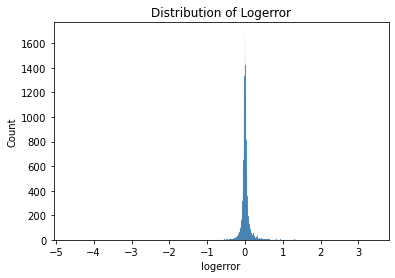

In [19]:
#taxvalue with outliers removed
sns.histplot(data=zillow.logerror)
plt.title('Distribution of Logerror')
plt.show()

In [20]:
#train validate test split
#split data using zillow_split function from prepare.py
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.zillow_split(zillow, 'logerror')

train -> (27011, 19)
validate -> (11577, 19)
test -> (9648, 19)


## Takeaways from Prepare 
- several columns were renamed in order to make them more legible
- duplicates were dropped on parcelid
- null values:
    - dropped if they fell outside of the threshold (0.5 column, 0.5 rows)
    - if fell inside the threshold, null values were imputed by 'mean' and 'most frequent'
- outliers were dropped from bedrooms, bathrooms, total_sqft columns
- created column titled "county" that uses county_code to name column
- final dataframe contains 48236 entries with 19 columns 

<hr style="border:2px solid black"> </hr>

## Explore

In [21]:
#function from explore.py
summary = explore.summarize(zillow)

Dataframe head: 
   parcelid  logerror  bathrooms  bedrooms  total_sqft  county_code  latitude  \
0  14297519  0.025595        3.5         4        3100         6059  33634931   
1  17052889  0.055619        1.0         2        1465         6111  34449266   
2  14186244  0.005383        2.0         3        1243         6059  33886168   

   longitude  lotsizesquarefeet  regionidcity  regionidcounty  regionidzip  \
0 -117869207               4506         53571            1286        96978   
1 -119281531              12647         13091            2061        97099   
2 -117823170               8432         21412            1286        97078   

   year_built  structuretaxvaluedollarcnt  value_assessed  \
0        1998                      485713         1023282   
1        1967                       88000          464000   
2        1962                       85289          564778   

   landtaxvaluedollarcnt  tax_amount transactiondate   county  
0                 537569       11013

In [22]:
#explore.plot_variable_pairs(train.drop(columns=['parcelid','transactiondate', 'county']))

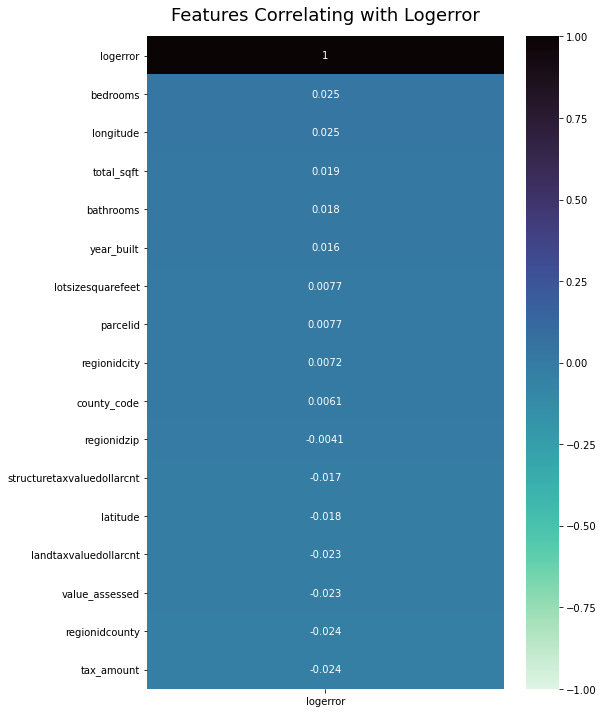

In [23]:
#see what correlates most with logerror
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(zillow.corr()[['logerror']].sort_values(by='logerror', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with Logerror', fontdict={'fontsize':18}, pad=16);

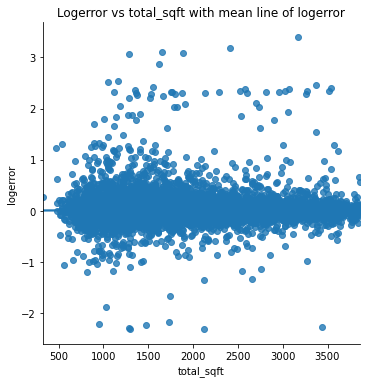

In [24]:
#visualize Log error vs total_sqft
sns.lmplot(x='total_sqft', y='logerror', data=train)
plt.title('Logerror vs total_sqft with mean line of logerror')
plt.show()

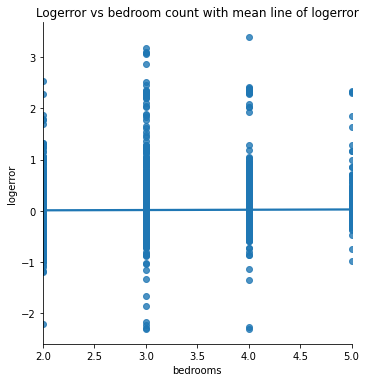

In [25]:
#visualize log error vs bedroom count
sns.lmplot(x='bedrooms', y='logerror', data=train)
plt.title('Logerror vs bedroom count with mean line of logerror')
plt.show()

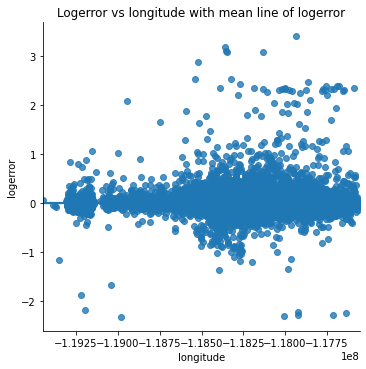

In [26]:
#visualize log error vs longitude
sns.lmplot(x='longitude', y='logerror', data=train)
plt.title('Logerror vs longitude with mean line of logerror')
plt.show()

In [27]:
numeric_cols = ['bathrooms', 'bedrooms', 'total_sqft',
       'county_code', 'latitude', 'longitude', 'lotsizesquarefeet',
       'regionidcity', 'regionidcounty', 'regionidzip', 'year_built',
       'structuretaxvaluedollarcnt', 'value_assessed', 'landtaxvaluedollarcnt',
       'tax_amount']

In [28]:
#use minmaxscaler function from prepare.py
X_train_scaled, X_validate_scaled, X_test_scaled = prepare.min_max_scaler(X_train, X_validate, X_test, numeric_cols)

In [29]:
X_train_scaled

,parcelid,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,county
45772,13863310,0.500000,0.333333,0.494904,0.297297,0.220949,0.765216,0.000327,0.055276,0.000000,0.003240,0.804348,0.076751,0.027714,0.014872,0.028292,2017-08-17,orange
8333,11848044,0.333333,0.000000,0.288788,0.000000,0.488290,0.693226,0.001551,0.006437,1.000000,0.001692,0.536232,0.046515,0.027103,0.020339,0.031665,2017-02-24,los_angeles
40587,11964889,0.666667,0.333333,0.370612,0.000000,0.526711,0.654546,0.000538,0.022785,1.000000,0.000211,0.956522,0.117965,0.032826,0.012127,0.035070,2017-07-24,los_angeles
19783,13863241,0.833333,0.333333,0.707248,0.297297,0.220198,0.763144,0.000388,0.055276,0.000000,0.003240,0.891304,0.152501,0.091243,0.069374,0.088927,2017-04-25,orange
38289,12544826,0.000000,0.333333,0.425821,0.000000,0.292202,0.684929,0.000547,0.108906,1.000000,0.000840,0.268116,0.081359,0.075133,0.066098,0.078098,2017-07-12,los_angeles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20599,12607086,0.000000,0.333333,0.213477,0.000000,0.332112,0.583283,0.000823,0.130337,1.000000,0.000596,0.550725,0.060864,0.056218,0.049453,0.056090,2017-04-28,los_angeles
11233,12164905,0.000000,0.333333,0.317950,0.000000,0.580850,0.688734,0.000600,0.110740,1.000000,0.001021,0.304348,0.037357,0.033535,0.029274,0.034440,2017-03-14,los_angeles
25333,17269390,0.333333,0.666667,0.371744,1.000000,0.575446,0.256368,0.001226,0.078325,0.426997,0.001215,0.666667,0.100188,0.030554,0.013238,0.028101,2017-05-19,ventura
31947,12115896,0.000000,0.000000,0.382786,0.000000,0.568910,0.702644,0.002064,0.110740,1.000000,0.001021,0.333333,0.016569,0.005440,0.002590,0.007751,2017-06-16,los_angeles


_______________________

## Hypothesis Testing:

- correlation testing: tests 2 continuous variables
- pearsons looks to find if two sample have a **linear** relationship
- r, p = stats.pearsonsr(x,y)

<br>

- T-Test: tests a continuous and a discrete variable
- t, p = stats.ttest_ind(x,y, equal_var= )


### Hypothesis 1: Sqft vs Logerror
- $H_0$: There is no correlation between logerror and total square feet of the property
- $H_a$: There is a correlation between logerror and total square feet of the property

In [30]:
#set alpha
alpha = .05

r, p = stats.pearsonr(train.total_sqft, train.logerror)
print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: 0.022 p-value: 0.0003


In [31]:
if p <alpha: 
    print('We fail to reject null hypothesis')
else:
    print('We reject our null hypothesis')

We fail to reject null hypothesis


____________________

### Hypothesis 2: Correlation Test (Longitude vs Logerror)
- $H_0$: There is no correlation between logerror and longitude
- $H_a$: There is a correlation between logerror and longitude

In [32]:
#set alpha
alpha = .05
#r,p = stats.pearsonsr(x,y)
r, p = stats.pearsonr(train.longitude, train.logerror)

print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: 0.0233 p-value: 0.0001


In [33]:
if p <alpha: 
    print('We fail to reject null hypothesis')
else:
    print('We reject our null hypothesis')

We fail to reject null hypothesis


_____________________

### Hypothesis 3: T-Test (Bedrooms vs Logerror)
- $H_0$: There is no relationship between logerror and bedroom count
- $H_a$: There is a relationship between logerror and bedroom count

In [34]:
#set alpha
alpha = .05

In [35]:
# sample size, must be more then 30 to meet assumption
train.logerror.count(), train.bathrooms.count()

(27011, 27011)

In [36]:
#check variance
train.value_assessed.var(), train.bathrooms.var()

#this shows not equal varient

(163143397675.23727, 0.5747274517350092)

In [37]:
#t-test on entire train set
t, p = stats.ttest_ind(train.bathrooms,train.logerror, equal_var=False)

print('t-value:',round(t,4),'p-value:',round(p,4))

t-value: 452.4726 p-value: 0.0


In [38]:
if p <alpha: 
    print('we fail to reject null hypothesis')
else:
    print('We reject our null hypothesis')

we fail to reject null hypothesis


<hr style="border:2px solid black"> </hr>

### Clustering

In [39]:
X = zillow[['bedrooms', 'longitude']]
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
kmeans.predict(X)

array([1, 2, 3, ..., 1, 1, 1], dtype=int32)

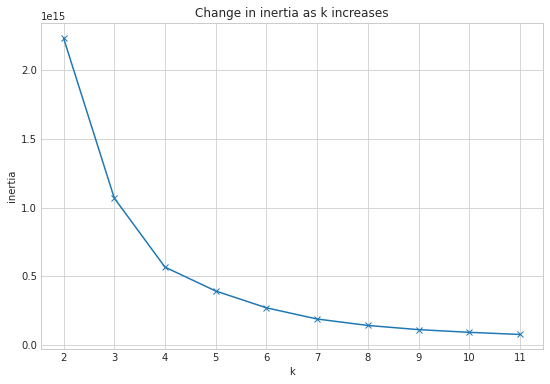

In [40]:
# let is explore what values of k might be appropriate

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [41]:
zillow['cluster'] = kmeans.predict(X)

In [42]:
kmeans.cluster_centers_

array([[ 3.49216590e+00, -1.18594959e+08],
       [ 3.31451089e+00, -1.17944199e+08],
       [ 3.44586196e+00, -1.19063809e+08],
       [ 3.40193772e+00, -1.17724710e+08],
       [ 3.01727632e+00, -1.18365414e+08],
       [ 3.06228586e+00, -1.18146213e+08]])

<Figure size 1008x648 with 0 Axes>

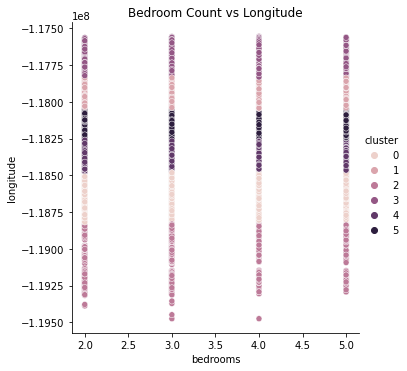

In [43]:
plt.figure(figsize=(14, 9))
sns.relplot(x = 'bedrooms', y = 'longitude', data = zillow, hue = 'cluster')
plt.title('Bedroom Count vs Longitude')
plt.show()

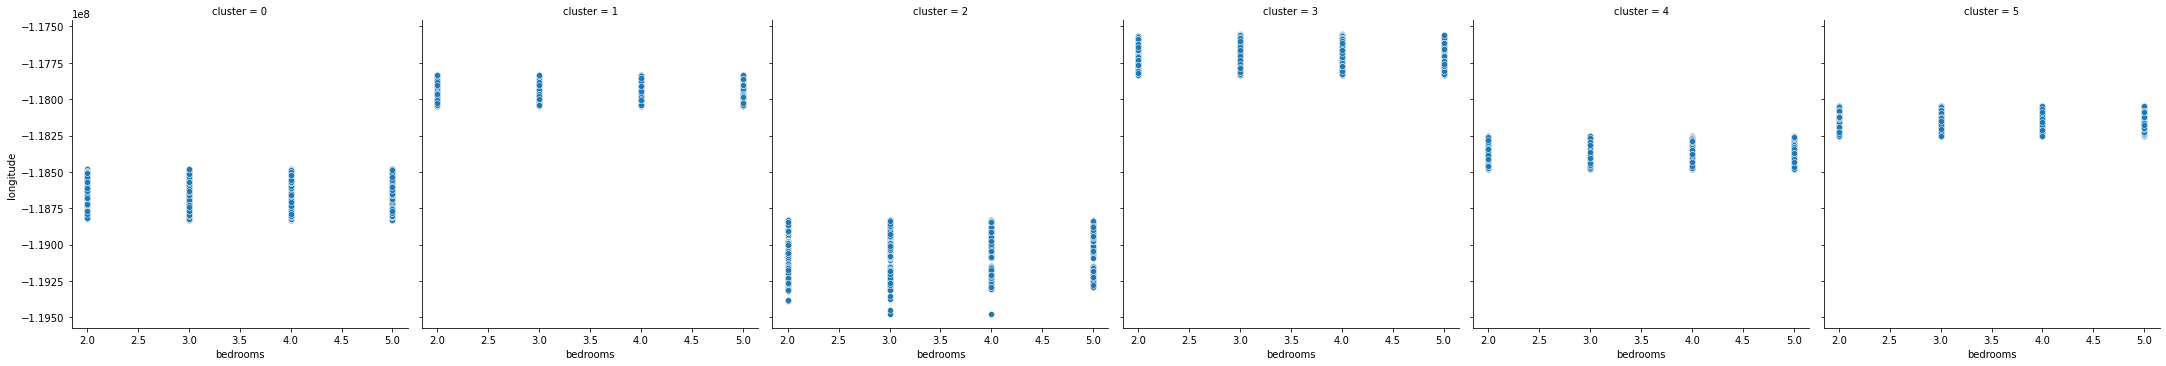

In [44]:
# plot different clusters

sns.relplot(x = 'bedrooms', y = 'longitude', data = zillow, col = 'cluster')

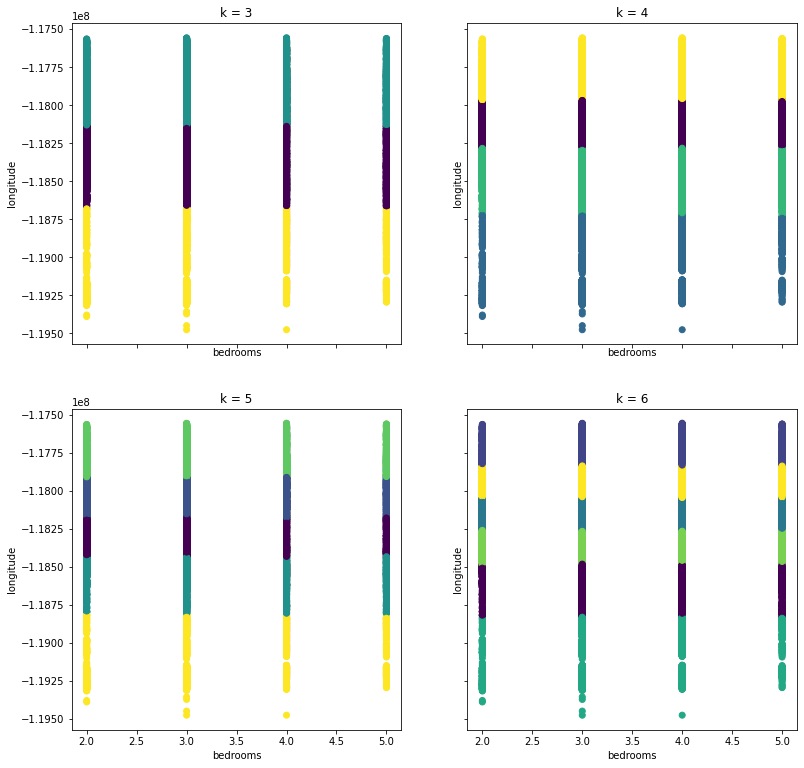

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(3, 7)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(X.bedrooms, X.longitude, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='bedrooms', ylabel='longitude')

# Model

In [46]:
X_train_scaled.head()

,parcelid,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,county
45772,13863310,0.500000,0.333333,0.494904,0.297297,0.220949,0.765216,0.000327,0.055276,0.0,0.003240,0.804348,0.076751,0.027714,0.014872,0.028292,2017-08-17,orange
8333,11848044,0.333333,0.000000,0.288788,0.000000,0.488290,0.693226,0.001551,0.006437,1.0,0.001692,0.536232,0.046515,0.027103,0.020339,0.031665,2017-02-24,los_angeles
40587,11964889,0.666667,0.333333,0.370612,0.000000,0.526711,0.654546,0.000538,0.022785,1.0,0.000211,0.956522,0.117965,0.032826,0.012127,0.035070,2017-07-24,los_angeles
19783,13863241,0.833333,0.333333,0.707248,0.297297,0.220198,0.763144,0.000388,0.055276,0.0,0.003240,0.891304,0.152501,0.091243,0.069374,0.088927,2017-04-25,orange
38289,12544826,0.000000,0.333333,0.425821,0.000000,0.292202,0.684929,0.000547,0.108906,1.0,0.000840,0.268116,0.081359,0.075133,0.066098,0.078098,2017-07-12,los_angeles


In [47]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame({'actual': y_train})
y_validate = pd.DataFrame({'actual': y_validate})
y_test = pd.DataFrame({'actual': y_test})

## Create Baseline

In [48]:
#create the baseline
baseline= y_train['actual'].mean()

In [49]:
#create column called baseline to compare
y_train['baseline'] = baseline

In [50]:
#calculate RMSE for baseline model
rmse_baseline_train= math.sqrt(mean_squared_error(y_train.actual, y_train.baseline))

In [51]:
# predict validate
y_validate['baseline'] = baseline

# evaluate: rmse
rmse_baseline_validate = math.sqrt(mean_squared_error(y_validate.actual, y_validate.baseline))

In [52]:
#create a dataframe to make data easier to visualize/understand
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_train': round(rmse_baseline_train, 4),
    'rmse_validate': round(rmse_baseline_validate, 4)
}])

metric_df
#we now have out baseline model to work off of

,model,rmse_train,rmse_validate
0,mean_baseline,0.1669,0.1794


In [53]:
#set features
#we do not want to include all columns in this because it could cause overfitting
features = ['total_sqft', 'bedrooms', 'longitude']

__________________

## OLS Model

In [54]:
#create the model 
lm = LinearRegression(normalize=True)

#fit the model
lm.fit(X_train_scaled[features], y_train.actual)

LinearRegression(normalize=True)

In [55]:
# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lm)**(1/2)

In [56]:
#create visual to see baseline vs LinearRegression model
metric_df = metric_df.append(
    {
    'model': 'OLS Model',
    'rmse_train': round(rmse_train, 4),
    'rmse_validate': round(rmse_validate,4),
    }, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.1669,0.1794
1,OLS Model,0.1668,0.1792


__________________________

## Lasso Lars Model

In [57]:
# create the model object
lars = LassoLars(alpha= 2)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled[features], y_train.actual)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lars)**(1/2)


In [58]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha 2',
    'rmse_train': round(rmse_train,4),
    'rmse_validate': round(rmse_validate,4),
    }, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.1669,0.1794
1,OLS Model,0.1668,0.1792
2,LassoLars alpha 2,0.1669,0.1794


____________________

## Tweedie Regressor Model

In [59]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled[features], y_train.actual)

# predict train
y_train['logerror_pred_glm'] = glm.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = (mean_squared_error(y_train.actual, y_train.logerror_pred_glm)**(1/2))

# predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_glm)**(1/2)


ValueError: Some value(s) of y are out of the valid range for family TweedieDistribution

In [ ]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'Tweedie Regressor: power=1, alpha =0',
    'rmse_train': round(rmse_train,4),
    'rmse_validate': round(rmse_validate,4),
    }, ignore_index=True)

metric_df